## Projeto de Séries temporais 
* Grupo: \
José Augusto/Artur Dartagnan

### Importando bibliotecas e dados;

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from lazypredict.Supervised import LazyRegressor

# Carregando os dados
data = pd.read_csv('DailyDelhiClimateTrain.csv')



In [3]:
# Analise descritiva dos dados
data.describe()



,meantemp,humidity,wind_speed,meanpressure
count,1462.00,1462.00,1462.00,1462.00
mean,25.50,60.77,6.80,1011.10
std,7.35,16.77,4.56,180.23
min,6.00,13.43,0.00,-3.04
25%,18.86,50.38,3.48,1001.58
50%,27.71,62.62,6.22,1008.56
75%,31.31,72.22,9.24,1014.94
max,38.71,100.00,42.22,7679.33


### Analise exploratoria dos dados;

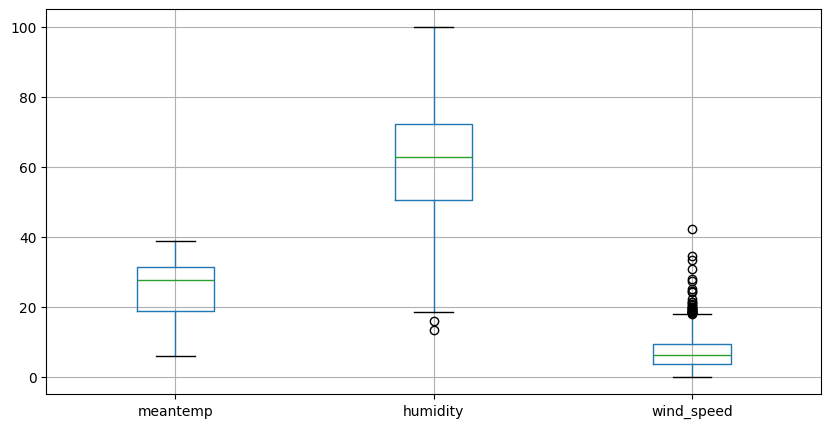

In [4]:
# Visualização dos dados - boxplots
data.boxplot(column=['meantemp', 'humidity', 'wind_speed'], figsize=(10, 5))
plt.show()


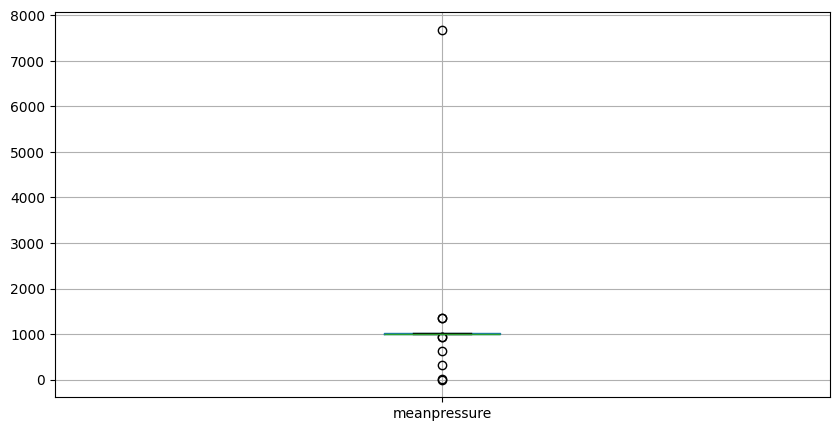

In [5]:
data.boxplot(column=['meanpressure'], figsize=(10, 5))
plt.show()

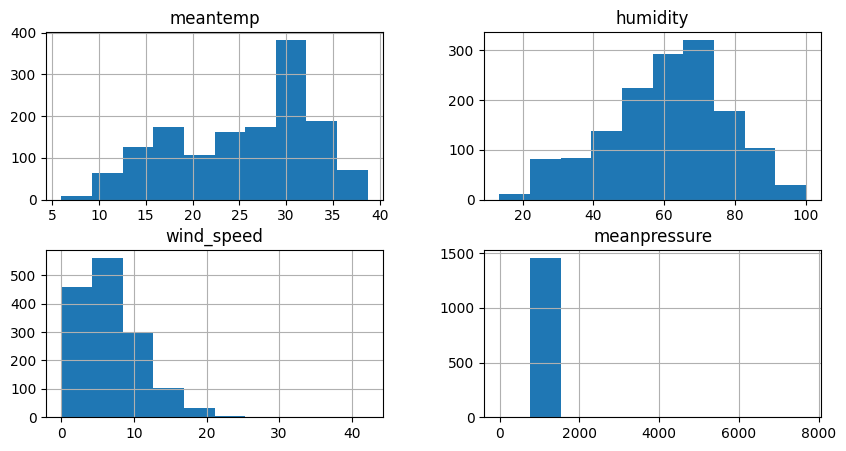

In [6]:
data.hist(column=['meantemp', 'humidity', 'wind_speed', 'meanpressure'], figsize=(10, 5))
plt.show()

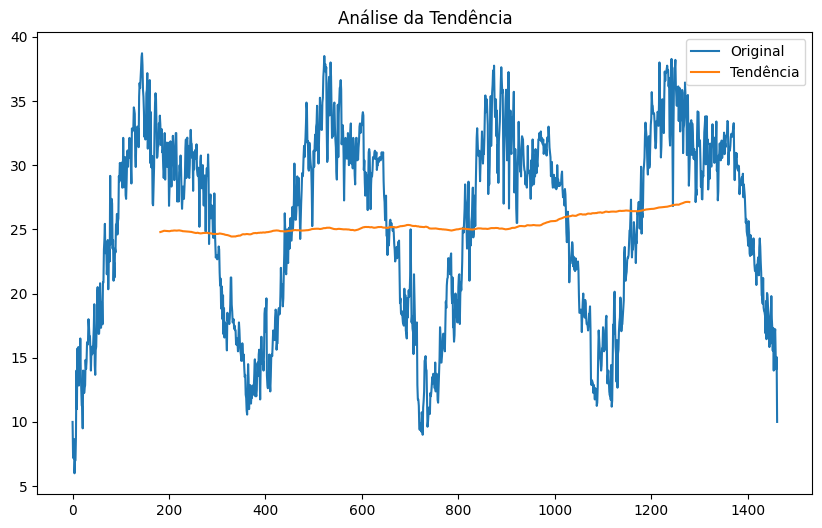

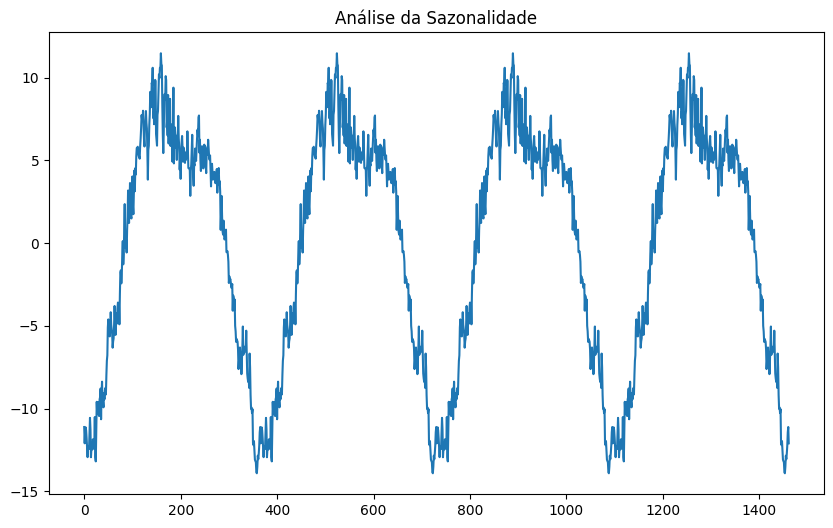

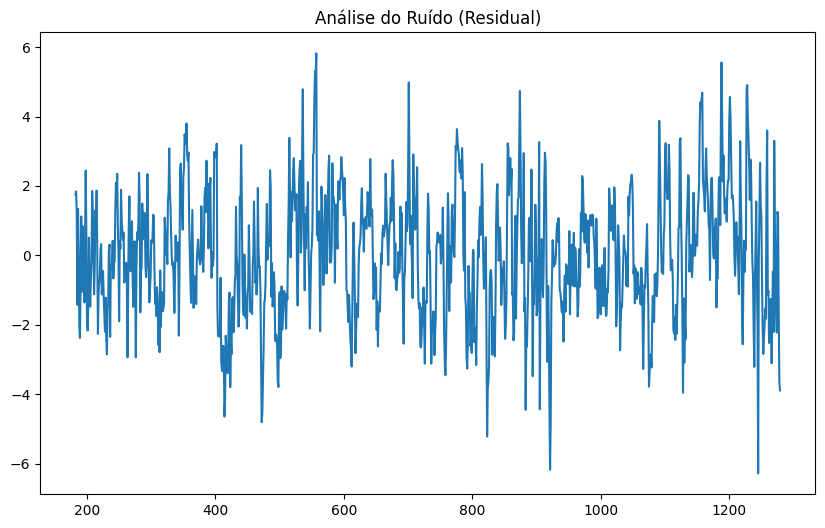

In [7]:
# Decomposição da série
decomposition = seasonal_decompose(data['meantemp'], model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Análise da tendência
plt.figure(figsize=(10, 6))
plt.plot(data['meantemp'], label='Original')
plt.plot(trend, label='Tendência')
plt.title('Análise da Tendência')
plt.legend()
plt.show()

# Análise da sazonalidade
plt.figure(figsize=(10, 6))
plt.plot(seasonal)
plt.title('Análise da Sazonalidade')
plt.show()

# Análise do ruído (residual)
plt.figure(figsize=(10, 6))
plt.plot(residual)
plt.title('Análise do Ruído (Residual)')
plt.show()




In [8]:
# Teste de estacionariedade
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    h0 = 'A série é não-estacionária.'
    h1 = 'A série é estacionária.'
    
    if result[1] > 0.05:
        print(h0)
    else:
        print(h1)
        

# Teste de estacionariedade para a série original	

adf_test(data['meantemp'])

ADF Statistic: -2.0210690559206714
p-value: 0.2774121372301609
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
A série é não-estacionária.


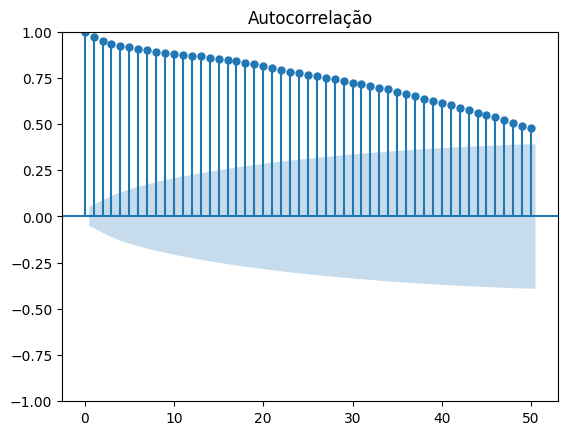

In [9]:


# Autocorrelação
plot_acf(data['meantemp'], lags=50)
plt.title('Autocorrelação')
plt.show()



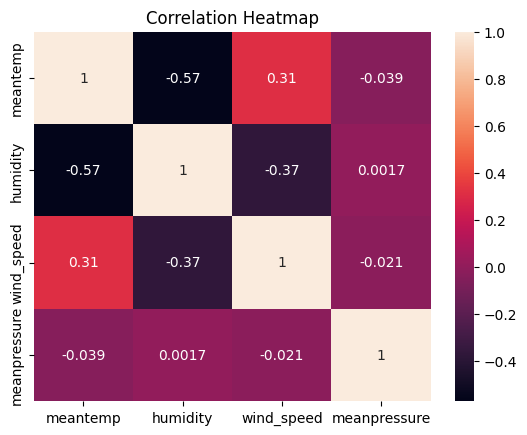

In [ ]:
# Heatmap para verificar a correlação entre as variáveis
# sns.heatmap(data.corr(), annot=True)
# plt.title('Correlation Heatmap')
# plt.show()

sns.heatmap(data.drop(columns=['date']).corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

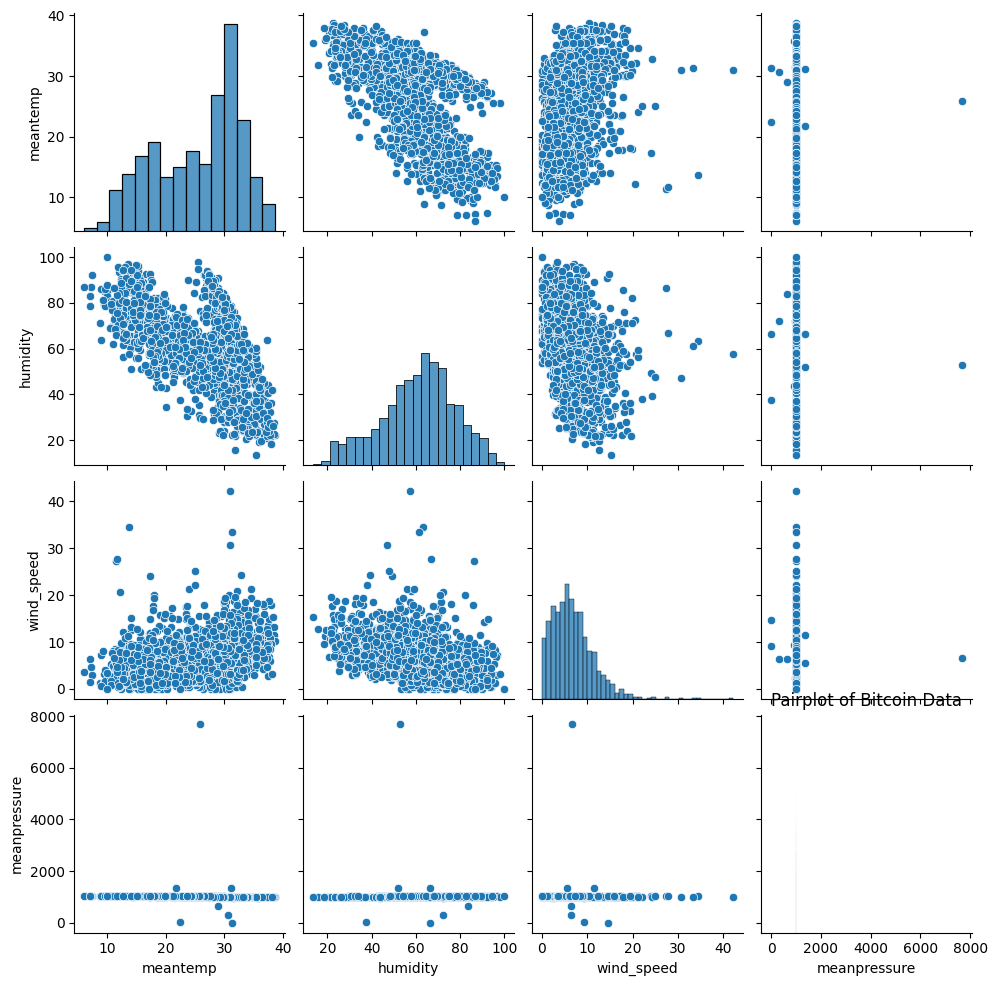

In [12]:
sns.pairplot(data)
plt.title('Pairplot of Bitcoin Data')
plt.show()

### Escolha do Modelo;

In [13]:
# Escolher a variável mais adequada para o target (considerando 'meantemp' como o target)

# LazyPredict para analisar qual o melhor modelo disponível
X = data.drop(columns=['date', 'meantemp'])
y = data['meantemp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = regressor.fit(X_train, X_test, y_train, y_test)

print(models)


  0%|          | 0/42 [00:00<?, ?it/s]

100%|██████████| 42/42 [00:08<00:00,  5.18it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1169, number of used features: 3
[LightGBM] [Info] Start training from score 25.641209
                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
GradientBoostingRegressor                    0.88       0.88    2.51   
RandomForestRegressor                        0.87       0.87    2.68   
HistGradientBoostingRegressor                0.86       0.86    2.71   
LGBMRegressor                                0.86       0.86    2.74   
ExtraTreesRegressor                          0.86       0.86    2.74   
BaggingRegressor                             0.86       0.86    2.75   
AdaBoostRegressor   

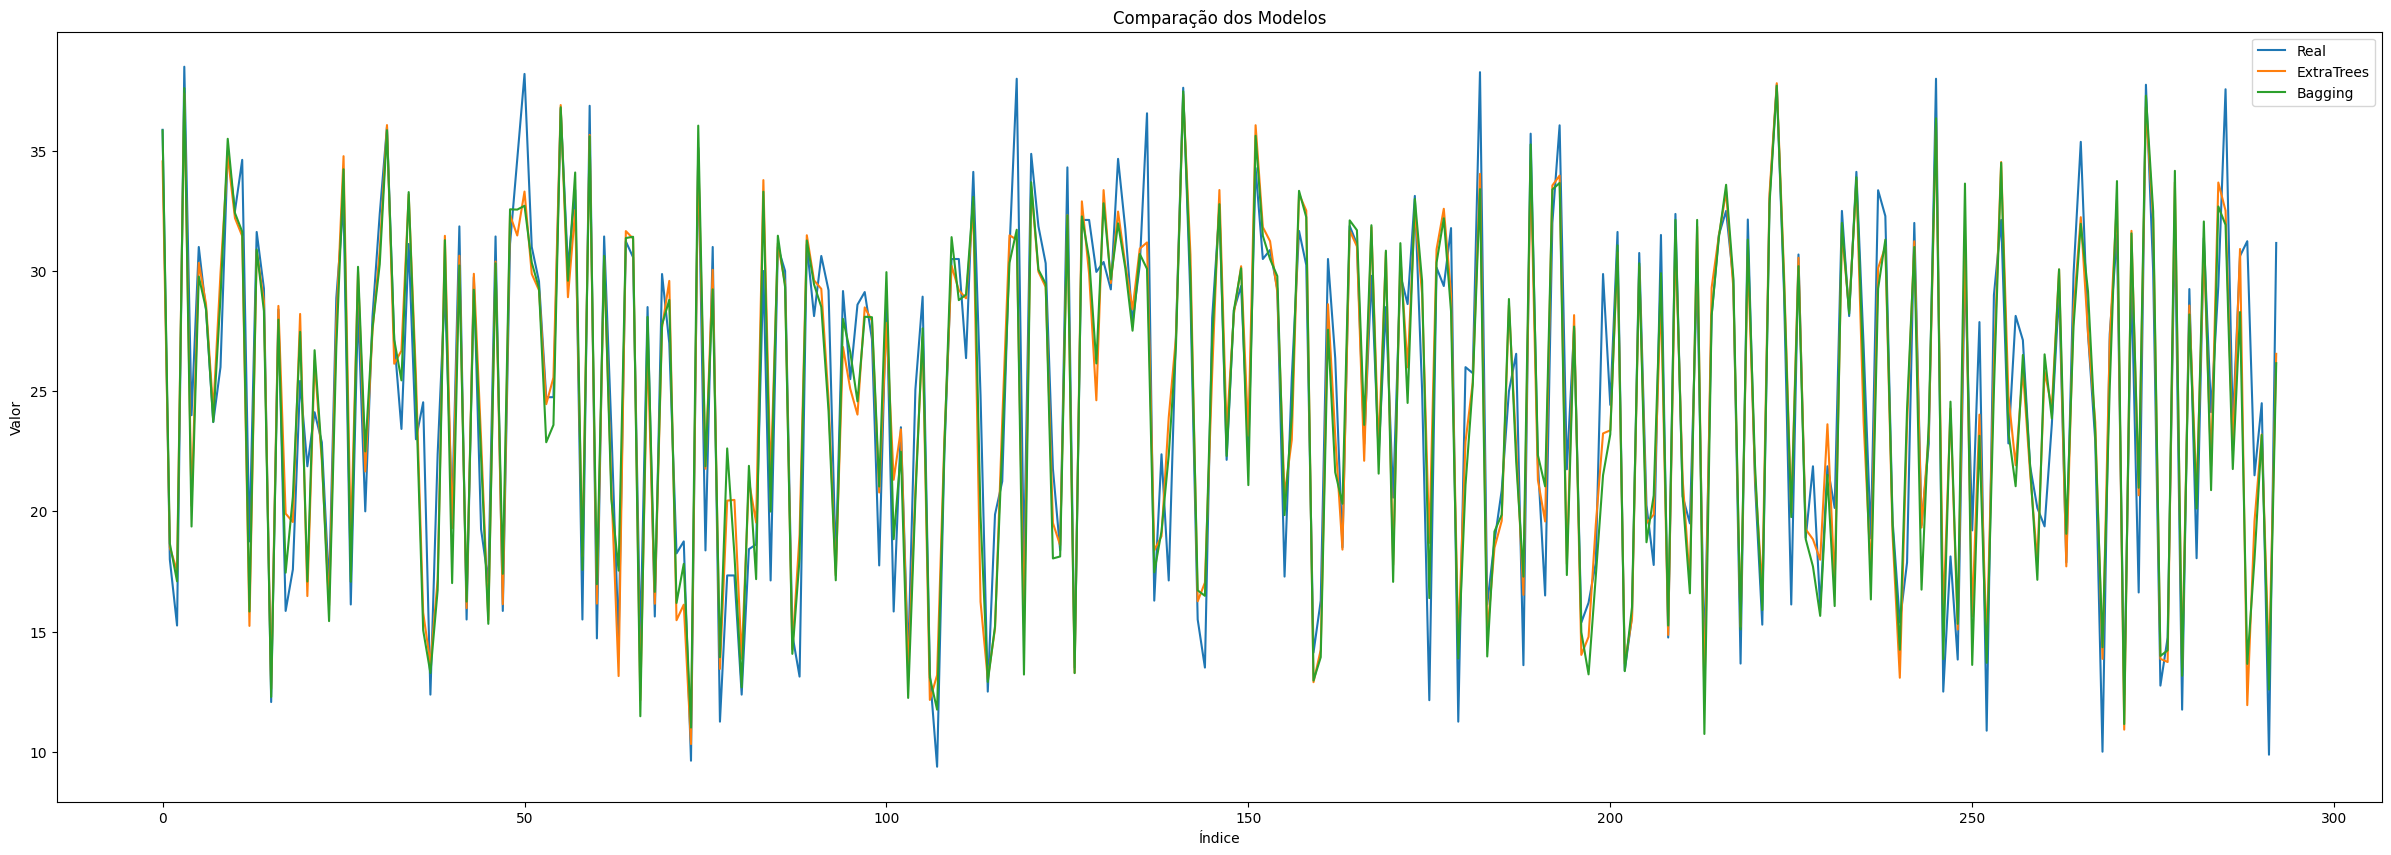

In [17]:
# Crie o modelo (separe os dados entre treino e teste)
model = ExtraTreesRegressor()
model.fit(X_train, y_train)

# Aplique o modelo ao teste
y_pred = model.predict(X_test)

# Faça o forecast
forecast = model.predict(X)

# Compare os modelos
#bagging_model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=42)
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=10, random_state=42)
bagging_model.fit(X_train, y_train)
bagging_pred = bagging_model.predict(X_test)

# Gráfico de comparação dos modelos
# plt.figure(figsize=(30, 10))
# plt.plot(y_test.values, label='Real')

# plt.plot(y_pred, label='ExtraTrees', marker='o')

# plt.plot(bagging_pred, label='Bagging', marker='x')

# plt.title('Comparação dos Modelos')
# plt.legend()
# plt.show()

plt.figure(figsize=(30, 10))
sns.lineplot(data=y_test.values, label='Real')
sns.lineplot(data=y_pred, label='ExtraTrees')
sns.lineplot(data=bagging_pred, label='Bagging')

plt.title('Comparação dos Modelos')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()
